In [1]:
import sys,os,glob
import pandas as pd
import numpy as np 
import scipy as sp
from scipy.stats import linregress as lin
import matplotlib.pyplot as plt
sys.path.append('../')
from ReadData import ReadFiles

In [2]:
files = glob.glob('data/*')
params = ['Heat Treatment','Gage Diameter','Extensometer Gage Length','Final Gage Diameter','Rockwell Hardness','Rockwell Scale','(s)']
q1dict = ReadFiles(files,params)
q1dict[]


Done :)
CSV labels are:  Index(['(s)', '(mm)', '(kN)', '(mm/mm)'], dtype='object')


## Question 1

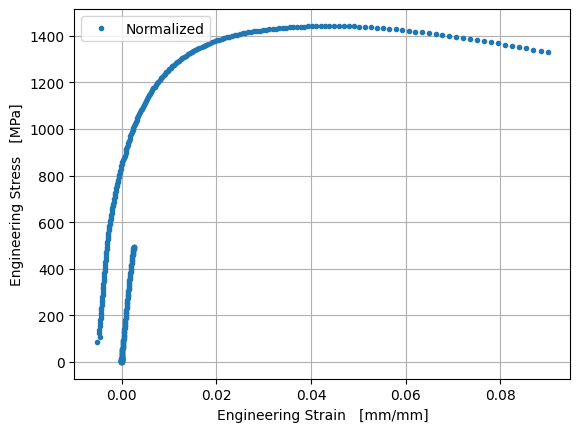

In [43]:
def stress(data,r):
    rad = r
    return 1000*data / np.pi / (rad**2)

def get_xy(Dict,key):
    dt = Dict[key]['data']
    r = np.float64(Dict[key]['Gage Diameter'])/2
    x,y = dt[:,3],stress(dt[:,2],r)
    x = x -x[0]
    ind = np.argmax(x)
    return x[:ind],y[:ind]

labels = ['Oil Quenched','Tempered at 300 C','Normalized','Tempered at 500 C','Annealed','Water Quenched']
for i,key in enumerate(q1dict.keys()):
    if key == 'NM':
        x,y = get_xy(q1dict,key)
        plt.plot(x[:-10],y[:-10],'.',label=labels[i])
plt.legend()
plt.grid()
plt.xlabel('Engineering Strain   [mm/mm]')
plt.ylabel('Engineering Stress   [MPa]')
plt.savefig('plots/bs_plot.png',dpi=600)


## Question 2

In [4]:
def brinnel(dic,key):
    val = np.float64(dic[key]['Rockwell Hardness'])
    typ = dic[key]['Rockwell Scale']
    return 33.22 * np.exp(0.0192*val) * (typ == 'HRB') + 131.7 * np.exp(0.0252*val) *(typ=='HRC')
def pltE(bounds,x,y,_plot=1):
    _x,_y  = x[bounds[0]:bounds[1]],y[bounds[0]:bounds[1]]
    
    m = lin(_x,_y).slope
    b = -0.002 * m
    xx = np.linspace(0.002,.01)
    yy = x*m + b
    offset = y[np.argmin(abs(y-yy))]
    if _plot:
        plt.plot(_x,_y)
        #plt.plot(xx,xx*m+b)
    return m/1e3,offset

def rd(arr,d=3):
    return np.around(arr,d)

def to_latex(arr):
    arr = np.array(arr) if type(arr) == list else arr
    arr = rd(arr) if arr.dtype=='float64' else arr
    string = [str(x)+' & ' for x in arr]
    string = ''.join(string)
    return string[:-3] + ' \\\\ \n\hline \n'
    

\textbf{Material} & Oil Quenched & Tempered at 300 C & Normalized & Tempered at 500 C & Annealed & Water Quenched \\ 
\hline 

\textbf{Youngs Modulus [GPa]} & 197.065 & 186.829 & 205.729 & 227.167 & 111.797 & 161.711 \\ 
\hline 

\textbf{Yield Strength} & 1138.428 & 1269.068 & 931.842 & 1148.958 & 402.874 & 1341.104 \\ 
\hline 

\textbf{Ultimate Strength} & 2013.803 & 1553.692 & 1442.464 & 1201.172 & 705.882 & 1341.104 \\ 
\hline 

\textbf{Toughness} & 86.562 & 166.139 & 131.696 & 142.251 & 155.675 & 7.386 \\ 
\hline 

\textbf{Percent Elongation} & 5.22 & 12.392 & 9.992 & 13.061 & 24.284 & 0.991 \\ 
\hline 

\textbf{Brinnel Hardness} & 264.692 & 309.453 & 238.109 & 247.905 & 1206.654 & 353.671 \\ 
\hline 



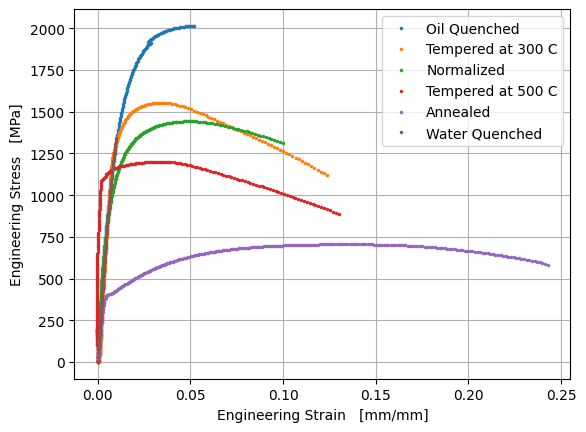

In [10]:
el_bounds= [[0,50],[80,150],[0,50],[105,140],[10,110],[0,50]]
material = []
offset = []
youngs = []
uts = []
per_elong = []
brinn  = []
tough = []

labels = ['Oil Quenched','Tempered at 300 C','Normalized','Tempered at 500 C','Annealed','Water Quenched']
for i,key in enumerate(q1dict.keys()):
    x,y = get_xy(q1dict,key)
    if i == 2:
        b = 117
        x,y = x[b:-7],y[b:-7]
        x = x - x[0]
    if i ==1 or i ==0 or i ==4:
        b = -7
        x,y = x[:b],y[:b]
    m,off = pltE(el_bounds[i],x,y,0)
    material.append('4340_'+key)
    youngs.append(m)
    offset.append(off)
    uts.append(max(y))
    per_elong.append((max(x)-min(x))*100)
    brinn.append(brinnel(q1dict,key))
    tough.append(np.trapezoid(y,x=x))
    
    plt.plot(x,y,'.',ms = 3,label=labels[i])
plt.grid()
plt.legend()
plt.xlabel('Engineering Strain   [mm/mm]')
plt.ylabel('Engineering Stress   [MPa]')
plt.savefig('plots/q1_adjusted.png',dpi=600)
#plt.close()



label = ['Material','Youngs Modulus [GPa]','Yield Strength','Ultimate Strength','Toughness','Percent Elongation','Brinnel Hardness']
for l,array in zip(label,[labels,youngs,offset,uts,tough,per_elong,brinn]):
    print('\\textbf{'+l+'}' + ' & ' + to_latex(array))  

## Question 4

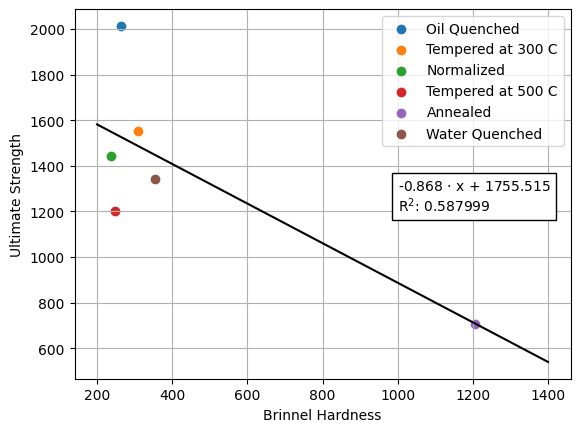

In [38]:
'''if len(brinn) == 6:
    ugly = -2
    brinn.pop(ugly)
    uts.pop(ugly)'''

def ufunc(x,a,b,c):
    return b*np.exp(c*x/1000 - a)
    
line = lin(brinn,uts)
pams = sp.optimize.curve_fit(ufunc,brinn,uts)[0]
func = lambda x : pams[1] * np.exp(x/1000 *pams[2] - pams[0])
x = np.linspace(200,1400)
for b,u,l in zip(brinn,uts,labels):
    plt.scatter(b,u,label = l)
plt.plot(x,line.slope*x + line.intercept,color = 'k')
plt.legend()
plt.grid()
plt.xlabel('Brinnel Hardness')
plt.ylabel('Ultimate Strength')
plt.text(1000,1200,f'{rd(line.slope)} $\cdot$ x + {rd(line.intercept)}\nR$^{2}$: {rd(line.rvalue**2,6)}',
         bbox=dict(facecolor='white', edgecolor='black', alpha=1.0))
plt.savefig('plots/q4.png',dpi=600)
plt.show()



## Question 6

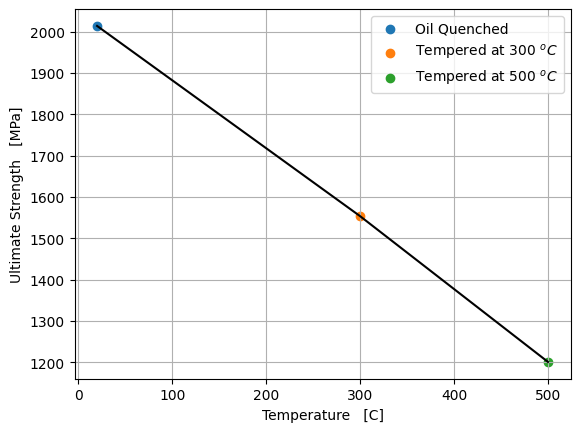

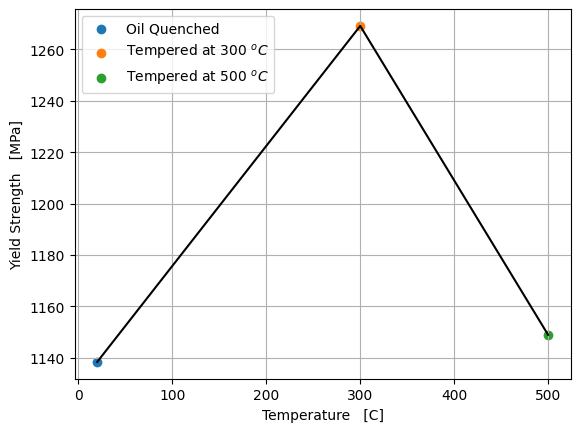

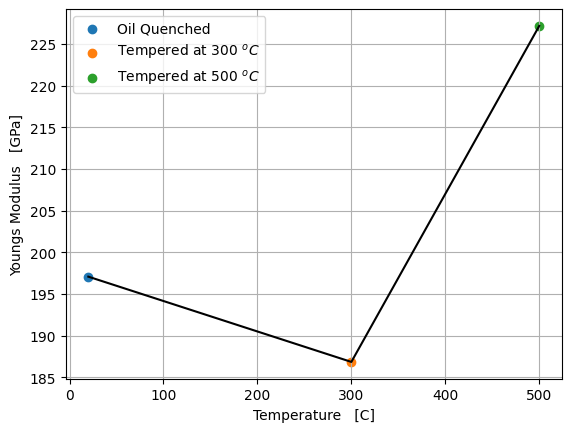

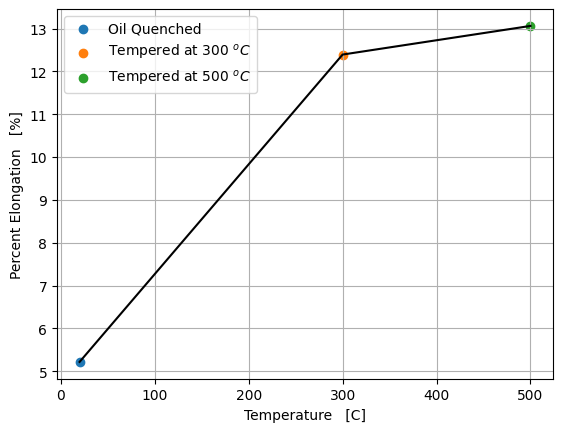

In [31]:
def plotter(y,ylab,savearg,_plot=1):
    plt.plot(temps,y,'k')
    labs = ['Oil Quenched','Tempered at 300 $^oC$','Tempered at 500 $^oC$']
    for _x,_y,l in zip(temps,y,labs):
        plt.scatter(_x,_y,label=l)
    plt.xlabel('Temperature   [C]')
    plt.ylabel(ylab)
    plt.grid()
    plt.legend()
    plt.savefig(f'plots/q6_{savearg}.png',dpi=600)
    if _plot:
        plt.show()
    plt.close()

_keys = [0,1,3]
temps = [20,300,500]

plotter([uts[i] for i in _keys],'Ultimate Strength   [MPa]','uts')
plotter([offset[i] for i in _keys],'Yield Strength   [MPa]','offset')
plotter([youngs[i] for i in _keys],'Youngs Modulus   [GPa]','youngs')
plotter([per_elong[i] for i in _keys],'Percent Elongation   [%]','per_elong')

In [39]:
q1dict['AN']['Rockwell Hardness']

'87.9'